In [61]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA



In [63]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Combine datasets on CustomerID
merged_df = pd.merge(customers, transactions, on='CustomerID')



In [65]:
# Feature Engineering
agg_data = merged_df.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count'],
    'TransactionDate': 'max'
}).reset_index()

agg_data.columns = ['CustomerID', 'TotalSpend', 'AvgTransactionValue', 'NumTransactions', 'LastTransactionDate']

# Recency calculation (days since last transaction)
agg_data['Recency'] = (pd.Timestamp.today() - pd.to_datetime(agg_data['LastTransactionDate'])).dt.days
agg_data.drop('LastTransactionDate', axis=1, inplace=True)



In [67]:
# Merge aggregated data with customer profile information
final_df = pd.merge(customers, agg_data, on='CustomerID')
final_df.drop(['CustomerID', 'CustomerName','SignupDate'], axis=1, inplace=True)  # Drop non-informative columns

# Encode categorical variables
final_df = pd.get_dummies(final_df, columns=['Region'], drop_first=True)



In [90]:
# Normalize numerical data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df)

# Perform K-Means clustering
k = 8  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
final_df['Cluster'] = kmeans.fit_predict(scaled_data)



C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index: 1.022255757444626
Silhouette Score: 0.3796091887944251


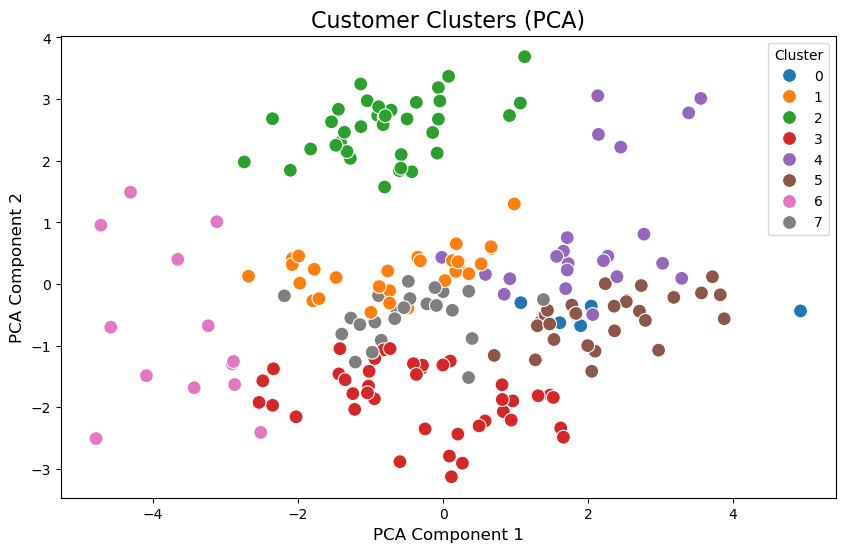

In [92]:
# Calculate Clustering Metrics
db_index = davies_bouldin_score(scaled_data, final_df['Cluster'])
silhouette_avg = silhouette_score(scaled_data, final_df['Cluster'])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

# Visualize Clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
final_df['PCA1'] = reduced_data[:, 0]
final_df['PCA2'] = reduced_data[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=final_df,
    palette='tab10', s=100
)
plt.title('Customer Clusters (PCA)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.show()

